In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.integrate import quad

from time import perf_counter as time

from tqdm import tqdm
from scipy import linalg, stats

from scipy.special import jacobi, legendre, roots_jacobi, eval_jacobi, factorial, gamma

from tb_utils import JacobiGL, constructV, constructVx, constructD, z2x, z2x_dz, x2z, x2z_dx, evaluate_jacobi_grid, constructMinv
from tb_utils import jacobi_p_normalisation_const

import warnings
warnings.filterwarnings('ignore')

## 2a) - simple BVP

In [2]:
eps = 0.1
x0, xN = 0, 1
g0, gN = 0, 0
a_pde, b_pde, c_pde = -eps, -1, 0

def f(x): return np.ones(x.shape[0])

def u_exact_solution(x, eps=eps): return (np.exp(-x/eps) + (x - 1) - np.exp(-1/eps)*x)/(np.exp(-1/eps) - 1)

### Collocation - LCM (nodal)

In [ ]:
alpha, beta = 0, 0 # Legendere polynomials
N = 10

def solve_bvp_simple(N):

    # z are the points in [-1,1]
    z = JacobiGL(alpha=alpha, beta=beta, N=N)
    D = constructD(z=z, alpha=alpha, beta=beta, a=x0, b=xN)
    x = z2x(z=z, a=x0, b=xN)

    # du/dz = D u => du/dx dx/dz = D u => du/dx = (1 / (dx/dz)) D u
    # x2z_dz_value = x2z_dx(x0, xN)
    # D = x2z_dz_value * D_z

    # in the slides there is a mistake, a is correct, -a is NOT correct
    # the scale factor is included in Vx which is used to construct D
    L_N = a_pde * D @ D + b_pde * D + c_pde * np.eye(N+1)
    L_N[0, :] = 0; L_N[0, 0] = 1
    L_N[N, :] = 0; L_N[N, N] = 1

    # print(f"{L_N.shape = }")
    # print(f"{np.linalg.cond(L_N) = }")
    # plt.spy(L_N)

    fx = f(x).copy()
    fx[0] = g0; fx[N] = gN

    # in nodal space
    u = linalg.solve(L_N, fx)

    V = constructV(z=z, alpha=alpha, beta=beta)
    # V = ((xN-x0)/2) * V ## not needed
    u_hat = linalg.solve(V, u)

    M_inv = constructMinv(z=z, V=V, alpha=alpha, beta=beta, a=x0, b=xN)

    error = u - u_exact_solution(x=x)
    e_l2_2 = error @ linalg.solve(M_inv, error)

    return e_l2_2, u, u_hat, z, x


e_l2_2, u, u_hat, z, x = solve_bvp_simple(N=N)

x_eval = np.linspace(x0, xN, 200)
A = evaluate_jacobi_grid(x_eval, x, alpha=alpha, beta=beta, a=x0, b=xN)
u_eval = A @ u_hat

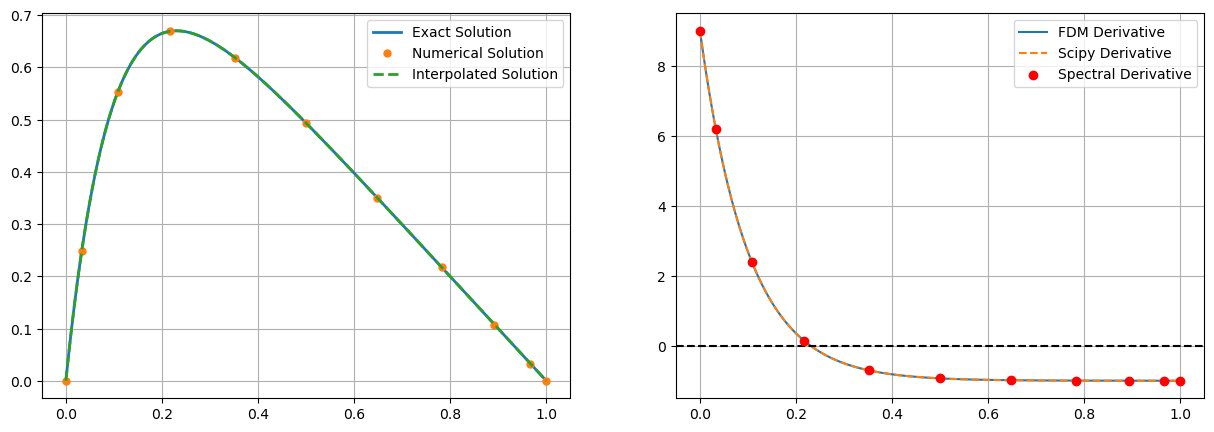

In [23]:
x_plot = np.linspace(x0, xN, 500)
u_exact_plot = u_exact_solution(x_plot, eps)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(x_plot, u_exact_plot, label="Exact Solution", linewidth=2)
ax[0].plot(x, u, 'o', label="Numerical Solution", markersize=5)
ax[0].plot(x_eval, u_eval, linestyle='--', label="Interpolated Solution", linewidth=2)
ax[0].grid();
ax[0].legend();


h = np.median(np.diff(x_plot))
du_dx_fdm = (u_exact_plot[2:] - u_exact_plot[:-2])/(2*h)

from scipy.differentiate import derivative
res = derivative(u_exact_solution, x_plot)

D = constructD(z=z, alpha=alpha, beta=beta, a=x0, b=xN)
du_dx_spectral = D @ u_exact_solution(x, eps)

ax[1].plot(x_plot[1:-1], du_dx_fdm, label="FDM Derivative");
ax[1].plot(x_plot, res.df, linestyle='--', label = "Scipy Derivative");
ax[1].scatter(x, du_dx_spectral, color='red', label="Spectral Derivative", zorder=5)
ax[1].axhline(0, color='k', linestyle='--')
ax[1].legend();
ax[1].grid();

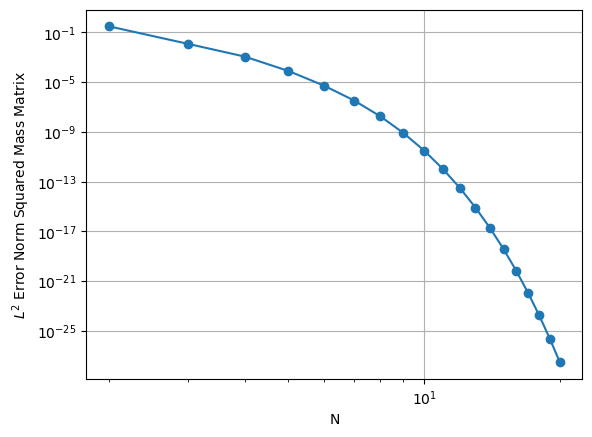

In [5]:
N_grid = np.arange(2, 21)
errors_l2_2 = np.zeros(N_grid.shape[0])

for i, N in enumerate(N_grid):
    e_l2_2, u, u_hat, z, x = solve_bvp_simple(N=N)
    errors_l2_2[i] = e_l2_2


plt.loglog(N_grid, errors_l2_2, 'o-')
plt.grid();
plt.xlabel("N")
plt.ylabel(r"$L^2$ Error Norm Squared Mass Matrix");

### Tau - LTM (modal)

#### Dense A

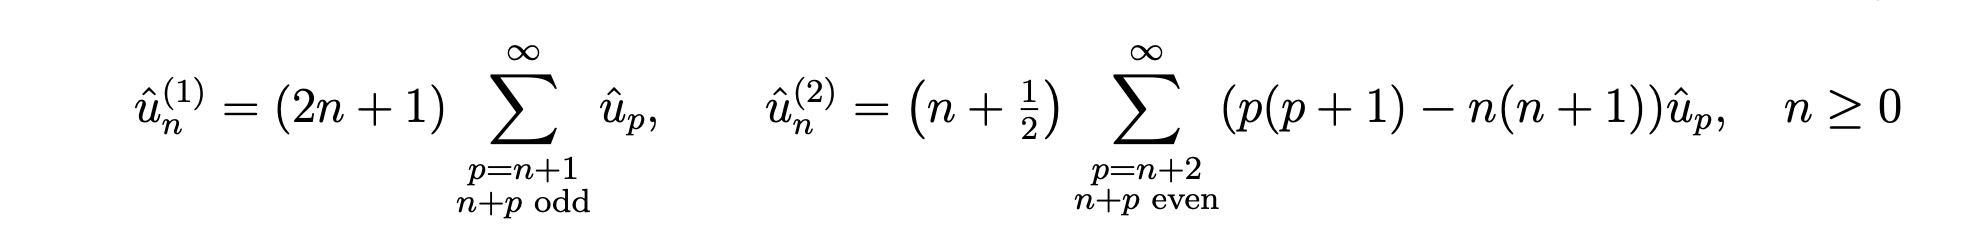

In [24]:
N = 10

def construct_deriv_matrices(N):

    n = np.arange(N+1)[:, None]   # column vector (rows)
    p = np.arange(N+1)[None, :]   # row vector (cols)

    # mask: above diagonal and n+p odd
    First_deriv_mask = (p >= n + 1) & (((n + p) % 2) == 1) 
    First_deriv_matrix = First_deriv_mask.astype(int)   # or float
    First_deriv_matrix = (2*n + 1) * First_deriv_matrix

    # mask: above diagonal and n+p even
    Second_deriv_mask = (p >= n + 2) & (((n + p) % 2) == 0) 
    Second_deriv_matrix = Second_deriv_mask.astype(int) * (p*(p + 1) - n*(n+1))
    Second_deriv_matrix = (n + 0.5) * Second_deriv_matrix

    return First_deriv_matrix, Second_deriv_matrix


def solve_bvp_ltm_simple(N):

    First_deriv_matrix, Second_deriv_matrix = construct_deriv_matrices(N=N)

    # accounting for the change of variables
    s = 2/(xN-x0)
    # s = (xN-x0) / 2
    First_deriv_matrix = s * First_deriv_matrix
    Second_deriv_matrix = s**2 * Second_deriv_matrix

    L_tau_naive = a_pde * Second_deriv_matrix + b_pde * First_deriv_matrix + c_pde * np.eye(N+1)

    z = JacobiGL(alpha=alpha, beta=beta, N=N)
    x = z2x(z=z, a=x0, b=xN)

    fx = f(x).copy()
    # fx[0] = g0; fx[N] = gN # probably not correct?
    V = constructV(z=z, alpha=alpha, beta=beta)
    fx_hat = linalg.solve(V, fx)

    row_left = N-1
    row_right = N
    fx_hat[row_left] = g0; fx_hat[row_right] = gN # because the BC are enforced in the modal space

    # norm_const = jacobi_p_normalisation_const(alpha=alpha, beta=beta, n=np.arange(N+1))
    # fx_hat = norm_const * fx_hat

    # BC, in the z domain !!!
    # L_tau_naive[0, :] = np.array([eval_jacobi(k, alpha, beta, x0) for k in range(N+1)])
    # L_tau_naive[N, :] = np.array([eval_jacobi(k, alpha, beta, xN) for k in range(N+1)])
    # L_tau_naive[0, :] = np.array([eval_jacobi(k, alpha, beta, x2z(x0, a=x0, b=xN)) for k in range(N+1)])
    # L_tau_naive[-1, :] = np.array([eval_jacobi(k, alpha, beta, x2z(xN, a=x0, b=xN)) for k in range(N+1)])

    L_tau_naive[row_left, :] = np.array([eval_jacobi(k, alpha, beta, x2z(x0, a=x0, b=xN)) for k in range(N+1)])
    L_tau_naive[row_right, :] = np.array([eval_jacobi(k, alpha, beta, x2z(xN, a=x0, b=xN)) for k in range(N+1)])

    print(f"{np.linalg.cond(L_tau_naive) = }")

    # in modal space
    u_hat = linalg.solve(L_tau_naive, fx_hat)

    u = V @ u_hat

    M_inv = constructMinv(z=z, V=V, alpha=alpha, beta=beta, a=x0, b=xN)

    error = u - u_exact_solution(x=x)
    e_l2_2 = error @ linalg.solve(M_inv, error)

    return e_l2_2, u, u_hat, z, x

e_l2_2, u, u_hat, z, x = solve_bvp_ltm_simple(N=N)

x_eval = np.linspace(x0, xN, 200)
A = evaluate_jacobi_grid(x_eval, x, alpha=alpha, beta=beta, a=x0, b=xN)
u_eval = A @ u_hat

np.linalg.cond(L_tau_naive) = np.float64(380.43689964458605)


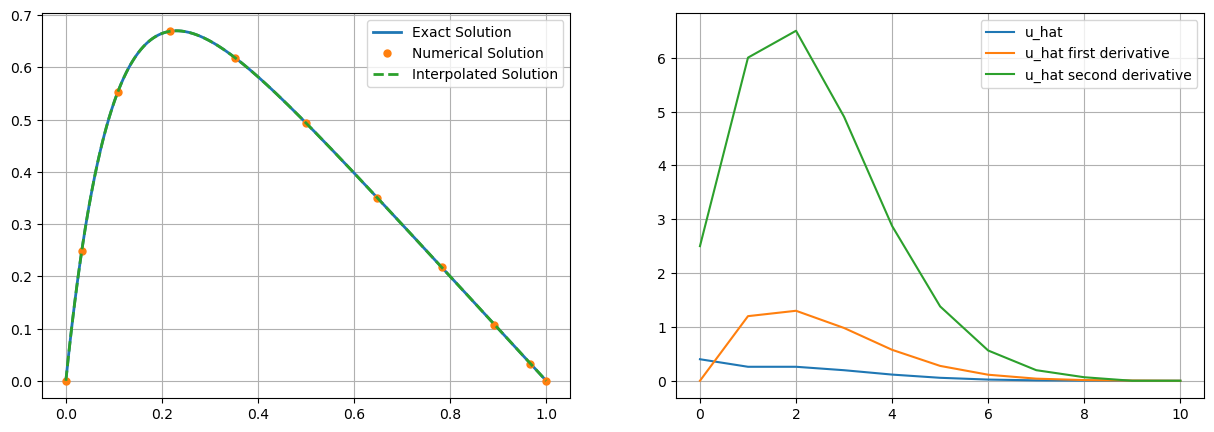

In [25]:
x_plot = np.linspace(x0, xN, 500)
u_exact_plot = u_exact_solution(x_plot, eps)

First_deriv_matrix, Second_deriv_matrix = construct_deriv_matrices(N=N)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(x_plot, u_exact_plot, label="Exact Solution", linewidth=2)
ax[0].plot(x, u, 'o', label="Numerical Solution", markersize=5)
ax[0].plot(x_eval, u_eval, linestyle='--', label="Interpolated Solution", linewidth=2)
ax[0].grid();
ax[0].legend();

ax[1].plot(np.abs(u_hat), label="u_hat");
ax[1].plot(np.abs(First_deriv_matrix @ u_hat), label="u_hat first derivative");
ax[1].plot(np.abs(Second_deriv_matrix @ u_hat), label="u_hat second derivative");
ax[1].grid();
ax[1].legend();

np.linalg.cond(L_tau_naive) = np.float64(6.031026693450304)
np.linalg.cond(L_tau_naive) = np.float64(23.938666000381527)
np.linalg.cond(L_tau_naive) = np.float64(20.38364853792422)
np.linalg.cond(L_tau_naive) = np.float64(43.56562096578532)
np.linalg.cond(L_tau_naive) = np.float64(72.61326229145672)
np.linalg.cond(L_tau_naive) = np.float64(118.37771023647176)
np.linalg.cond(L_tau_naive) = np.float64(181.134223915714)
np.linalg.cond(L_tau_naive) = np.float64(267.3403840978368)
np.linalg.cond(L_tau_naive) = np.float64(380.43689964458605)
np.linalg.cond(L_tau_naive) = np.float64(527.7382790656471)
np.linalg.cond(L_tau_naive) = np.float64(713.3773894432637)
np.linalg.cond(L_tau_naive) = np.float64(946.1074818945168)
np.linalg.cond(L_tau_naive) = np.float64(1230.6328846395922)
np.linalg.cond(L_tau_naive) = np.float64(1577.173043959477)
np.linalg.cond(L_tau_naive) = np.float64(1990.9909451524768)
np.linalg.cond(L_tau_naive) = np.float64(2483.7768710977716)
np.linalg.cond(L_tau_naive) = np.fl

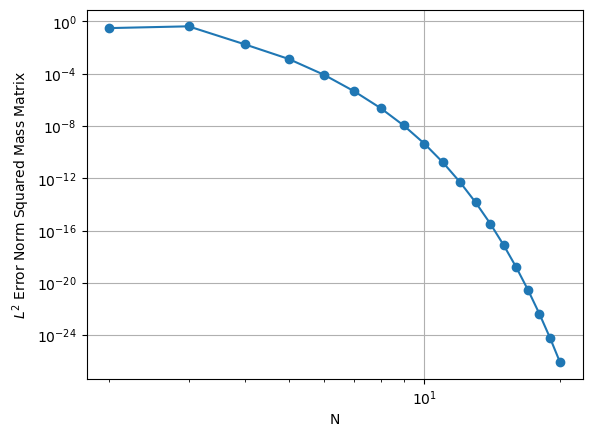

In [26]:
N_grid = np.arange(2, 21)
errors_l2_2 = np.zeros(N_grid.shape[0])

for i, N in enumerate(N_grid):
    e_l2_2, u, u_hat, z, x = solve_bvp_ltm_simple(N=N)
    errors_l2_2[i] = e_l2_2


plt.loglog(N_grid, errors_l2_2, 'o-')
plt.grid();
plt.xlabel("N")
plt.ylabel(r"$L^2$ Error Norm Squared Mass Matrix");

#### Matrices Legengre verification - they work

In [15]:
N = 50

First_deriv_matrix, Second_deriv_matrix = construct_deriv_matrices(N=N)

z = JacobiGL(alpha=alpha, beta=beta, N=N)
V = constructV(z=z, alpha=alpha, beta=beta)

def u_function(x): return 1.0 / (2.0 - np.cos(np.pi*(x + 1)))

u = u_function(z)

u_hat = linalg.solve(V, u)

x_eval = np.linspace(-1, 1, 200)
A = evaluate_jacobi_grid(x_eval, x_nodes=z, alpha=alpha, beta=beta, a=-1, b=1)

u_eval = A @ u_hat

def u_function_deriv(x):
    return -np.pi * np.sin(np.pi * (x + 1)) / (2.0 - np.cos(np.pi * (x + 1)))**2

u_deriv = u_function_deriv(z)
u_deriv_hat = linalg.solve(V, u_deriv)
u_deriv_eval = A @ u_deriv_hat

def u_function_deriv_2(x):
    num = (2.0 - np.cos(np.pi * (x + 1))) * np.cos(np.pi * (x + 1)) \
          - 2.0 * np.sin(np.pi * (x + 1))**2
    den = (2.0 - np.cos(np.pi * (x + 1)))**3
    return -np.pi**2 * num / den

u_deriv_2 = u_function_deriv_2(z)
u_deriv_2_hat = linalg.solve(V, u_deriv_2)
u_deriv_2_eval = A @ u_deriv_2_hat

In [16]:
u_deriv_hat_spectral = First_deriv_matrix @ u_hat
print(f"{np.linalg.norm(u_deriv_hat - u_deriv_hat_spectral) = }")

u_deriv_2_hat_spectral = Second_deriv_matrix @ u_hat
print(f"{np.linalg.norm(u_deriv_2_hat - u_deriv_2_hat_spectral) = }")

np.linalg.norm(u_deriv_hat - u_deriv_hat_spectral) = np.float64(1.5925266895257708e-12)
np.linalg.norm(u_deriv_2_hat - u_deriv_2_hat_spectral) = np.float64(4.0472294930304164e-10)


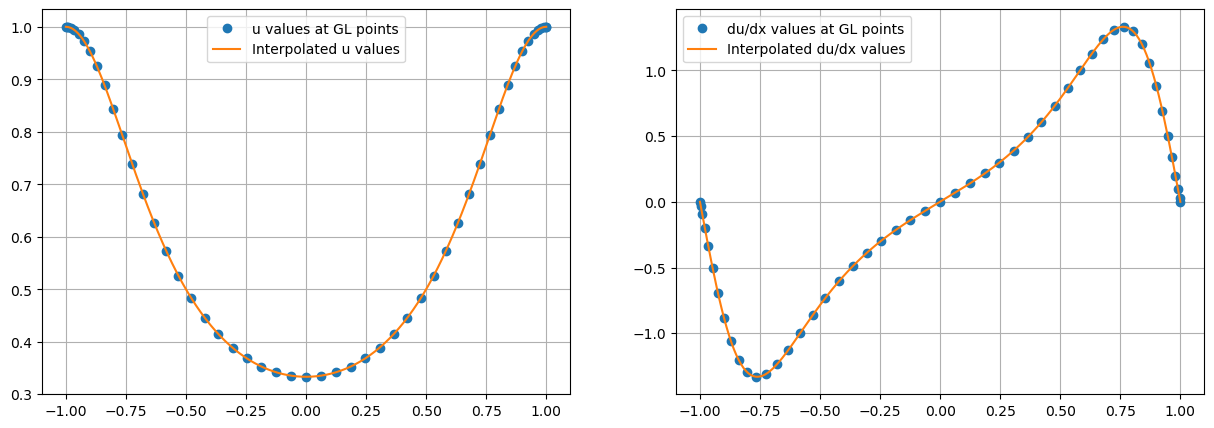

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(z, u, 'o', label="u values at GL points")
ax[0].plot(x_eval, u_eval, '-', label="Interpolated u values")
ax[0].grid()
ax[0].legend()

ax[1].plot(z, u_deriv, 'o', label="du/dx values at GL points")
ax[1].plot(x_eval, u_deriv_eval, '-', label="Interpolated du/dx values")
ax[1].grid()
ax[1].legend()

#### Sparse A - exploit when solving Ax=b (Woodbury)

In [ ]:

def build_A_and_G(N, a, b, c):
    """
    Build dense matrices A, G (size (N+1)x(N+1)) such that:
      A @ u_hat = G @ f_hat_in

    Coeffs (for n=0..N):
      a_{n,n-2} = -(c/a) / ((2n-1)(2n-3))       for n>=2
      a_{n,n-1} = -(b/a) / (2n-1)               for n>=1
      a_{n,n}   =  (c/a) * 2 / ((2n-1)(2n+3)) - 1
      a_{n,n+1} =  (b/a) / (2n+3)               for n<=N-1
      a_{n,n+2} = -(c/a) / ((2n+3)(2n+5))       for n<=N-2

      g_{n,n-2} = -(1/a) / ((2n-1)(2n-3))       for n>=2
      g_{n,n}   =  (1/a) * 2 / ((2n-1)(2n+3))
      g_{n,n+2} = -(1/a) / ((2n+3)(2n+5))       for n<=N-2
    """
    if a == 0:
        raise ValueError("Parameter 'a' must be nonzero.")

    Np1 = N + 1
    n = np.arange(Np1, dtype=float)

    A = np.zeros((Np1, Np1), dtype=float)
    G = np.zeros((Np1, Np1), dtype=float)

    # Common denom
    denom_c = (2*n - 1) * (2*n + 3)

    # Diagonal entries
    A[np.arange(Np1), np.arange(Np1)] = (c/a) * (2.0 / denom_c) - 1.0
    G[np.arange(Np1), np.arange(Np1)] = (1.0/a) * (2.0 / denom_c)

    # Sub-diagonal (n,n-1)
    idx = np.arange(1, Np1)
    A[idx, idx-1] = -(b/a) / (2*idx - 1)

    # Super-diagonal (n,n+1)
    idx = np.arange(0, N)
    A[idx, idx+1] = (b/a) / (2*idx + 3)

    # Sub-2-diagonal (n,n-2)
    idx = np.arange(2, Np1)
    A[idx, idx-2] = -(c/a) / ((2*idx - 1) * (2*idx - 3))
    G[idx, idx-2] = -(1.0/a) / ((2*idx - 1) * (2*idx - 3))

    # Super-2-diagonal (n,n+2)
    idx = np.arange(0, N-1)
    A[idx, idx+2] = -(c/a) / ((2*idx + 3) * (2*idx + 5))
    G[idx, idx+2] = -(1.0/a) / ((2*idx + 3) * (2*idx + 5))

    return A, G

# Usage:
N = 10
a, b, c = 1.0, 0.3, 2.0
A, G = build_A_and_G(N, a, b, c)

# Given modal f_hat_in:
f_hat_in = np.random.randn(N+1)
g_out = G @ f_hat_in  # RHS vector
# Solve for u_hat: u_hat = np.linalg.solve(A, g_out)

In [37]:
np.linalg.cond(G)

np.float64(473.345531732057)

## 2b) - complex BVP, flow cylinder

In [38]:
r1 = 1
r2 = 2
V_inf = 1

def exact_solution(r, theta): return V_inf * (r + (r1**2)/r) * np.cos(theta)